## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import spacy

from tqdm import tqdm

import gensim
from gensim import models
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

import multiprocessing

%matplotlib inline

In [2]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
#random.shuffle(congress_tweets)
# Shuffle the DataFrame rows
congress_tweets = congress_tweets.sample(frac=1, random_state=42)  # Using a random seed for reproducibility
# Subset to 11,000 random tweets
congress_tweets = congress_tweets.head(11000)
congress_tweets.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670"
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:

def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

def keep_alphanumeric(text):
    # Regular expression to match non-alphanumeric characters
    non_alphanumeric_pattern = re.compile(r'[^a-zA-Z0-9 ]')
    return non_alphanumeric_pattern.sub('', text)

def rem_punc_stop(text):
    stop_words = STOP_WORDS
    
    nlp.Defaults.stop_words |= {"RT","AMP","&","amp","QT"} ###removes the "RT" tag in addition to the normal set of stopwords.

    punc = set(punctuation)
    
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [4]:
# preprocessing and re-create "tokens" column
congress_tweets['text'] = congress_tweets['text'].map(lambda x: remove_urls(x)) # remove urls
#congress_tweets['text'] = congress_tweets['text'].map(lambda x: remove_emojis(x)) # remove emojis
congress_tweets['text'] = congress_tweets['text'].map(lambda x: keep_alphanumeric(x)) # only keep alphanumeric text
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) 

In [5]:
congress_tweets.to_csv('processed_tweets.csv', index=False)


## Part 2: Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: Word Counts By Party

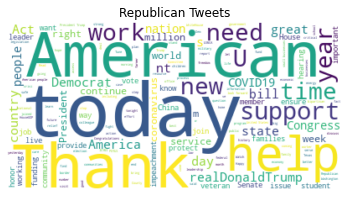

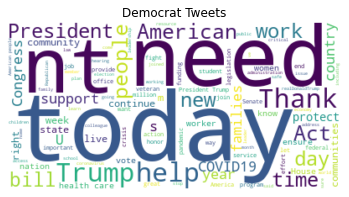

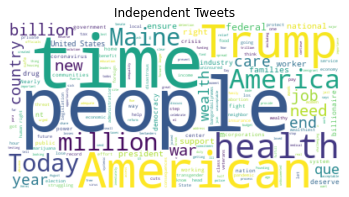

In [6]:
# Subset data to only include rows where the "name" field is "Nancy Pelosi and Ted Cruz"
rep_congress_tweets = congress_tweets[congress_tweets['party'].isin(['Republican'])]
dem_congress_tweets = congress_tweets[congress_tweets['party'].isin(['Democrat'])]
ind_congress_tweets = congress_tweets[congress_tweets['party'].isin(['Independent'])]



# apply function to text object
text = ' '.join(rep_congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.title("Republican Tweets")
plt.show()                             # show the plot

# apply function to text object
text = ' '.join(dem_congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.title("Democrat Tweets")
plt.show()                             # show the plot
# apply function to text object
text = ' '.join(ind_congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.title("Independent Tweets")
plt.show()                             # show the plot

### EDA 2: Document Length

In [7]:
# create new feature columns with counts of # of characters and # of words
# ----------

# count number of characters
congress_tweets['tweet_len'] = congress_tweets['tokens'].apply(len)

# count number of words
congress_tweets['word_count'] = congress_tweets['tokens'].apply(lambda x: len(str(x).split()))


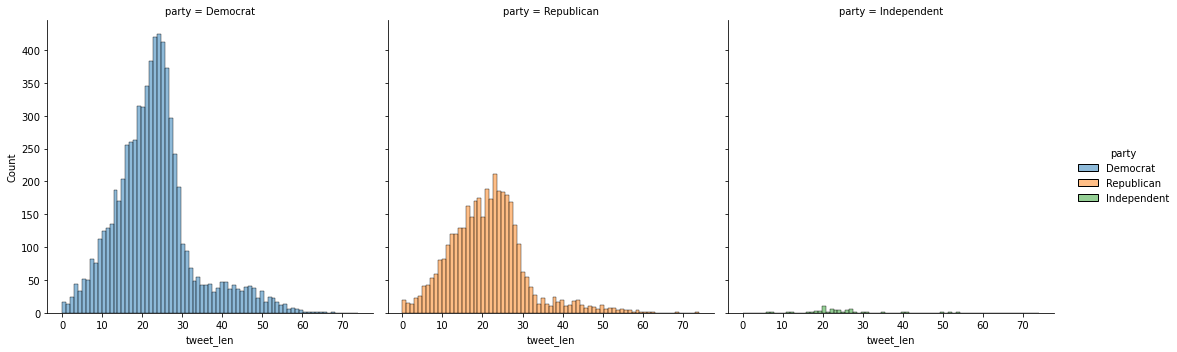

In [8]:
# create histogram of tweet length (number of characters)
sns.displot(congress_tweets,              # specify data
            x="tweet_len", #feature
           hue = "party",  # color by party 
            col = "party")  # color by party) 
plt.show()

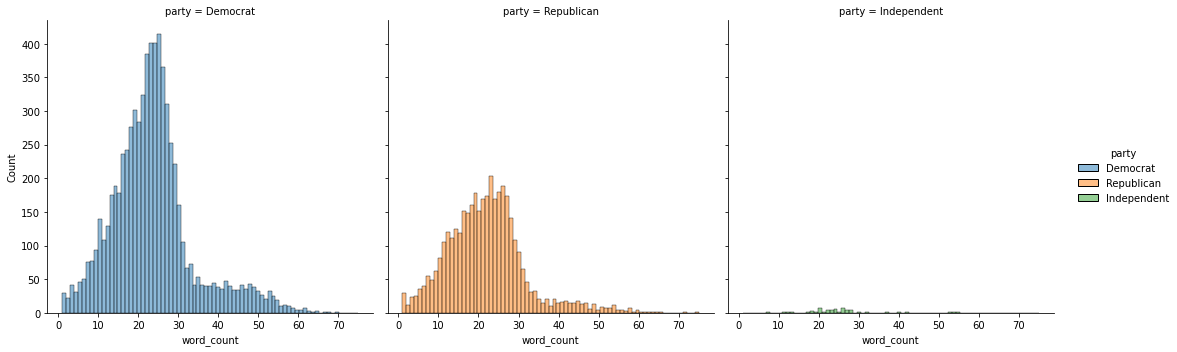

In [9]:
# create histogram of tweet length (number of characters)
sns.displot(congress_tweets,              # specify data
            x="word_count", #feature
           hue = "party",  # color by party 
            col = "party")  # color by party) 
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

### Response

Surprisingly, Ted Cruz and Nancy Pelosi have similar sentiment density plots. This may be because of the time-frame associated with our dataset, as the politicians may have tweeted more neutral or positive things during the initial stages of the COVID pandemic. 

In [10]:
# create a feature colum of sentiment polarity
# ---------- 
# create the "tokens" column again 
congress_tweets['tokens2'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

# create the "tokens" column again 
congress_tweets['polarity'] = congress_tweets['tokens2'].map(lambda text: TextBlob(text).sentiment.polarity)


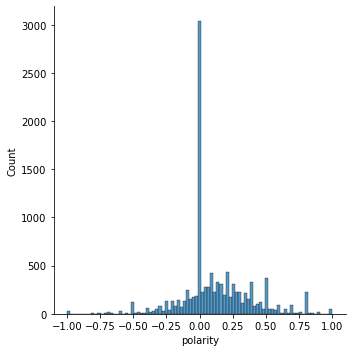

In [11]:
# histogram of combined polarity
sns.displot(congress_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()

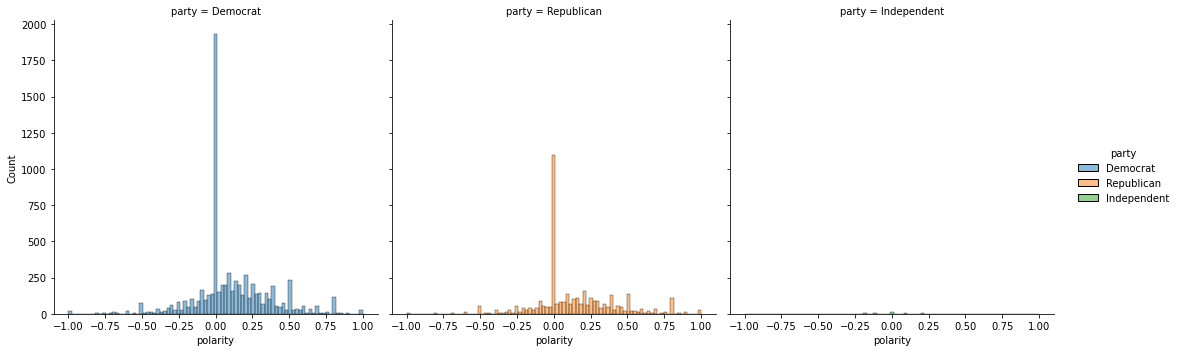

In [12]:
# histogram of word count by parties
sns.displot(congress_tweets,             # specify data
            x="polarity",   # x-axis feature
            hue = "party",  # color by party 
            col = "party")  # color by party 
plt.show()

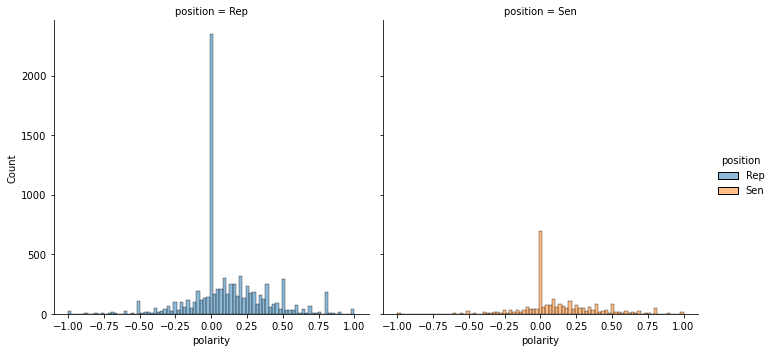

In [13]:
# histogram of word count by Rep vs Senator
sns.displot(congress_tweets,             # specify data
            x="polarity",   # x-axis feature
            hue = "position",  # color by rep/sen 
            col = "position")  # color by rep/sen 
plt.show()

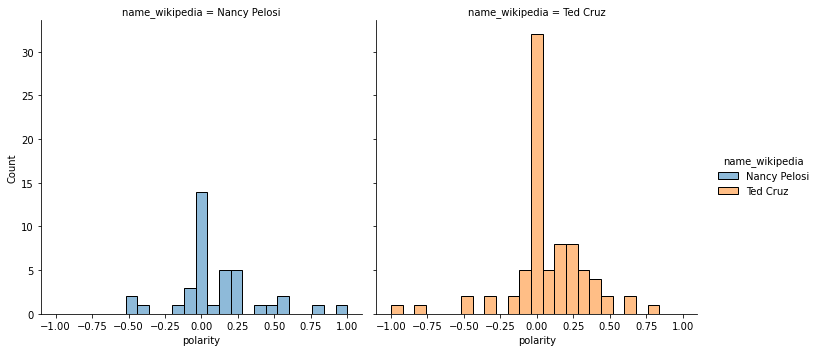

In [14]:
# Subset data to only include rows where the "name" field is "Nancy Pelosi and Ted Cruz"
n_t_congress_tweets = congress_tweets[congress_tweets['name_wikipedia'].isin(['Nancy Pelosi', 'Ted Cruz'])]
sns.displot(n_t_congress_tweets,             # specify data
            x="polarity",   # x-axis feature
            hue = "name_wikipedia",  # color by Name 
            col = "name_wikipedia")  # color by Name 
plt.show()

#sns.scatterplot(data=n_t_congress_tweets, x="polarity", hue="name_wikipedia")
#print(n_t_congress_tweets.head())


## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [15]:
#drop independents
congress_tweets = congress_tweets[congress_tweets['party'] != 'Independent']


In [16]:
# Non-text features
# --------
# select non-text features
non_text_features = congress_tweets[[#'screen_name', 
                          #'name_wikipedia',
                          'position', 
                          #'joined_congress_date',
                          #'birthday', 
                          'gender',
                          'state',
                         'district_number',
                         'party',
                         'trump_2016_state_share',
                         'clinton_2016_state_share',
                         'obama_2012_state_share',
                         'romney_2012_state_share']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)


In [17]:
non_text_features_dummies

,position_Rep,position_Sen,gender_F,gender_M,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,...,"romney_2012_state_share_634,892","romney_2012_state_share_647,744","romney_2012_state_share_692,634","romney_2012_state_share_710,746","romney_2012_state_share_730,617","romney_2012_state_share_740,600","romney_2012_state_share_754,175","romney_2012_state_share_891,325","romney_2012_state_share_92,698","romney_2012_state_share_971,869"
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10932,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10933,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10934,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10935,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Engineered Text Features

In [18]:
# Engineered Features
engineered_features = congress_tweets[['tweet_len', 
                            'word_count', 
                            'polarity']].reset_index(drop = True)
engineered_features

,tweet_len,word_count,polarity
0,47,48,0.350000
1,6,7,0.200000
2,20,20,0.000000
3,34,34,0.000000
4,23,23,0.208333
...,...,...,...
10932,17,17,0.350000
10933,5,6,0.000000
10934,16,17,0.700000
10935,16,17,-0.291667


### Non-text features + Engineered Features

In [19]:
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features)


### Bag-of-words or Tf-idf

In [20]:
# Join tokens within each document into a single string
congress_tweets['tokens'] = congress_tweets['tokens'].apply(lambda x: ' '.join(x))

# Initialize the Bag-of-Words CountVectorizer
countvec = CountVectorizer(stop_words=list(STOP_WORDS), 
                           ngram_range=(2,3))

# Fit and transform on tokens
ngrams = countvec.fit_transform(congress_tweets['tokens'])         

# Create a dataframe out of ngram sparse matrix - need to densify because DataFrame can't handle sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), 
                                    columns=countvec.get_feature_names_out())


/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'qt', 'rt', 've'] not in stop_words.
  warnings.warn(


In [21]:
# create dataframe of n-grams and their frequency 
# ----------

# create a datamframe by summing over the dictionary_dataframe from above and resetting the index
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view the first few lines
df_ngram.head()

,ngrams,freq
0,health care,278
1,american people,212
2,president trump,204
3,small businesses,184
4,united states,125


In [22]:
#for tfidf create a new data object called X
X = congress_tweets['tokens']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

In [23]:
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),                # specify matrix
                        columns = tf.get_feature_names_out())  # set feature names

In [24]:
# combine non-text features with tf-idf  
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

### Word Embedding

In [25]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 
googlenews_word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True)


In [26]:
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#from tqdm import tqdm

# Convert tokens to TaggedDocument format
#tagged_data = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(congress_tweets['tokens'])]

# Initialize Doc2Vec model
#model_dbow = Doc2Vec(dm=0,              # training algorithm: distributed bag of words
 #                    vector_size=300,   # word embedding size
  #                   negative=5,        # how many negative samples
   #                  hs=0,              # hierarchical softmax using negative samples
    #                 min_count=2,       # ignores all words with a total frequency lower than this threshold.
     #                sample=0,          # how much downsampling - 0 means none
      #               seed=1995, 
       #              workers=7)         # how many cores will be used - will not be fully reproducible however

# Build vocabulary
#model_dbow.build_vocab(tagged_data)


In [27]:
# loop over our data
# ----------
#for epoch in range(1,30):
 #   model_dbow.train(utils.shuffle([x for x in tqdm(congress_tweets['tokens'].values)]), 
  #                   total_examples=len(congress_tweets['tokens'].values), 
   #                  epochs=epoch)
    #model_dbow.alpha -= 0.002
    #model_dbow.min_alpha = model_dbow.alpha

In [28]:
# preprocessing and re-create "tokens" column
congress_tweets['text'] = congress_tweets['text'].map(lambda x: remove_urls(x)) # remove urls
#congress_tweets['text'] = congress_tweets['text'].map(lambda x: remove_emojis(x)) # remove emojis
congress_tweets['text'] = congress_tweets['text'].map(lambda x: keep_alphanumeric(x)) # only keep alphanumeric text
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) 


In [29]:
congress_tweets['tokens']

908961    [RepKClark, 22, million, Americans, filed, une...
175615       [Thanks, came, tonights, forum, GOPTaxLaw,   ]
64613     [RepFilemonVela, Dreamers, TPS, recipients, es...
783091    [HispanicCaucus, JoaquinCastrotx, TheBlackCauc...
553399    [Thank, NYGovCuomo, today, face, extreme, weat...
                                ...                        
628255    [12, The, process, sure, valid, ballots, valid...
658998                [Wishing, family, blessed, Easter,  ]
784109    [Rankandfile, Dems, concerned, nt, articulatin...
544554    [DrRichBesser, Americas, families, hit, hard, ...
39167     [My, Democratic, colleagues, continuing, block...
Name: tokens, Length: 10937, dtype: object

In [30]:
# retrain google on your own corpus
# ----------

## specify your corpus
your_corpus = congress_tweets['tokens']  # Load your corpus here, make sure it's tokenized
#
## initialize Word2Vec model with the same dimensions as the Google News vectors
word2vec_model = gensim.models.Word2Vec(vector_size=300,    # word embedding size
                                        window=5,           # window size
                                        min_count=1,        # ignores words w/ frequency lower than this threshold
                                        workers=7)  # how many cores will be used
#
## build vocabulary 
word2vec_model.build_vocab(your_corpus)
#
## initialize word vectors using the Google News pre-trained vectors
word2vec_model.wv.vectors = googlenews_word2vec_model.vectors
#
## training model
word2vec_model.train(your_corpus, 
                     total_examples=len(your_corpus), 
                     epochs=5, 
                     compute_loss=True)

words = list(word2vec_model.wv.index_to_key)
print(words[0:100])  # print the first 100 words

[' ', 'I', 'The', 'We', 'nt', 'This', 'people', 'Trump', 'need', 'help', 'House', 'COVID19', 'Act', 'American', 'President', 'today', 'work', 'health', 'Congress', 'time', 'm', 'Americans', 'support', '  ', 'bill', 'US', 'Today', 's', 'country', 'families', 'Senate', 'care', 'Its', 'continue', 'communities', 'years', 'Thank', 'protect', 'new', 'workers', 'federal', 'community', 'working', 'It', 'like', 'public', 'legislation', 'day', 'realDonaldTrump', 'right', 'Democrats', 'week', 'important', 'ensure', 'proud', 'vote', 'bipartisan', 'passed', 'businesses', 'crisis', 'As', 'If', 've', 'law', 'great', 'funding', 'know', 'coronavirus', 'year', 'lives', 'family', 'In', 'women', 'state', 'fight', 'safe', 'My', 'pandemic', 'America', 'small', 'relief', 'access', 'honor', 'million', 'provide', 'office', 'students', 'Our', 'national', 'service', 'pass', 'That', 'local', 'stop', 'forward', 'A', 'children', 'government', 'join', 'want']


In [31]:
import numpy as np

def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    if len(doc) > 0:
        return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)  # Return zero vector if doc is empty or no words are found in the vocabulary


In [32]:
import numpy as np
# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for puppy in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(word2vec_model, puppy))
    
# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# print averages
doc_average_embeddings

array([[ 0.15915556,  0.12850881,  0.18164474, ..., -0.11753584,
         0.39881384, -0.28858453],
       [ 0.00508874,  0.15969324,  0.14942437, ..., -0.18962739,
         0.08972033, -0.05357941],
       [ 0.16104314,  0.02925523,  0.27357513, ..., -0.07360483,
         0.28574851, -0.36204493],
       ...,
       [-0.10005354,  0.22076546,  0.14041708, ..., -0.09796309,
         0.34316272, -0.02436796],
       [ 0.16401137,  0.07012075,  0.14100023, ..., -0.10173552,
         0.2774795 , -0.29941779],
       [ 0.10788441,  0.1639751 ,  0.38317254, ..., -0.16912046,
         0.33563596, -0.3155736 ]])

In [33]:
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

### Predicting Party

In [34]:
# create a list of dataframes from the objects created above
dataframes = [engineered_features, 
              tfidf_df,
             word2vec_features_df]


# create a list of labeles based on the objects created above
featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features',
                          'w2vec']

# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])

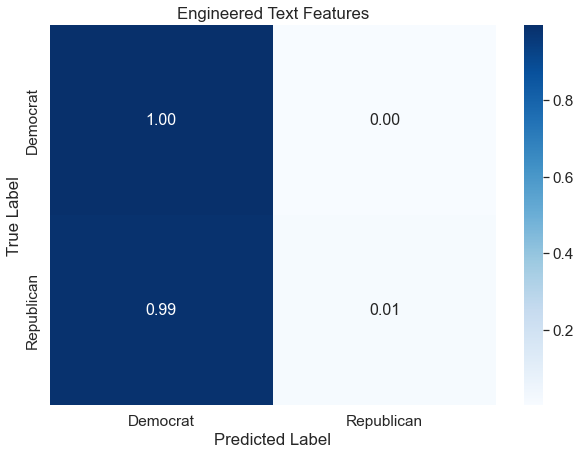

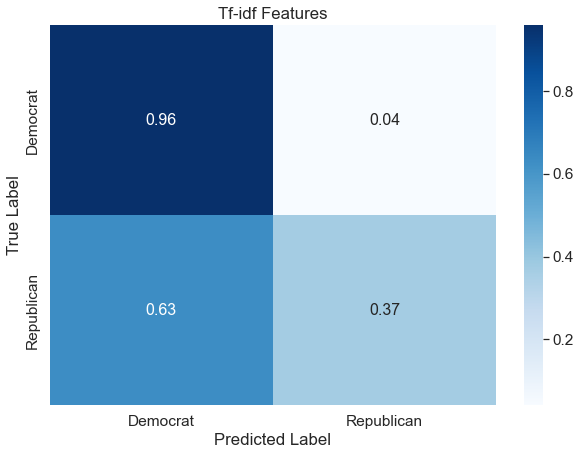

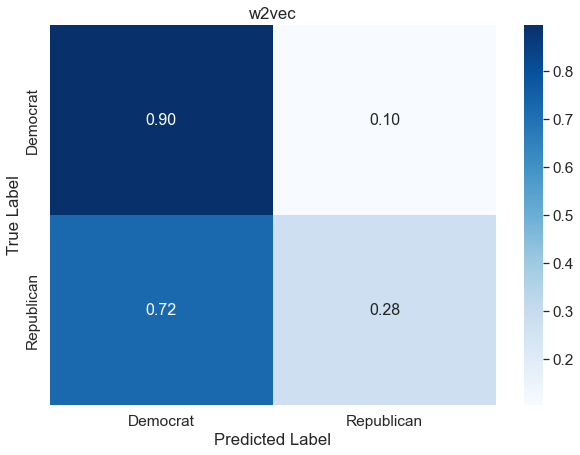

Featurization Technique: Engineered Text Features
Accuracy: 0.66
Recall: 0.01
Precision: 0.64
F1 Score: 0.02


Featurization Technique: Tf-idf Features
Accuracy: 0.76
Recall: 0.37
Precision: 0.83
F1 Score: 0.51


Featurization Technique: w2vec
Accuracy: 0.68
Recall: 0.28
Precision: 0.58
F1 Score: 0.37




In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Initialize lists to store metrics
accuracies = []
recalls = []
precisions = []
f1_scores = []

# Loop over each dataframe, apply a logit classification model, and create a confusion matrix
for dataframe, featurization in zip(dataframes, featurization_technique):

    # Changing column names to strings because some are integers
    dataframe.columns = dataframe.columns.astype(str)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(dataframe, y, train_size=0.80, test_size=0.20, random_state=10)

    # Apply Logit model
    logit_reg = LogisticRegression(max_iter=500)
    logit_model = logit_reg.fit(X_train, y_train.ravel())
    y_pred = logit_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append metrics to lists
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

    # Create confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
    df_cm = pd.DataFrame(cf_matrix, index=["Democrat", "Republican"], columns=["Democrat", "Republican"])

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', cmap='Blues')
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Display evaluation metrics
for featurization, accuracy, recall, precision, f1 in zip(featurization_technique, accuracies, recalls, precisions, f1_scores):
    print(f"Featurization Technique: {featurization}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")


### Predicting House/Senate

In [41]:
# create a list of dataframes from the objects created above
dataframes = [engineered_features, 
              tfidf_df,
             word2vec_features_df]


# create a list of labeles based on the objects created above
featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features',
                          'w2v']

# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])
congress_tweets[['position_binary','position']]

,position_binary,position
908961,0,Rep
175615,0,Rep
64613,0,Rep
783091,0,Rep
553399,0,Rep
...,...,...
628255,0,Rep
658998,0,Rep
784109,1,Sen
544554,1,Sen


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


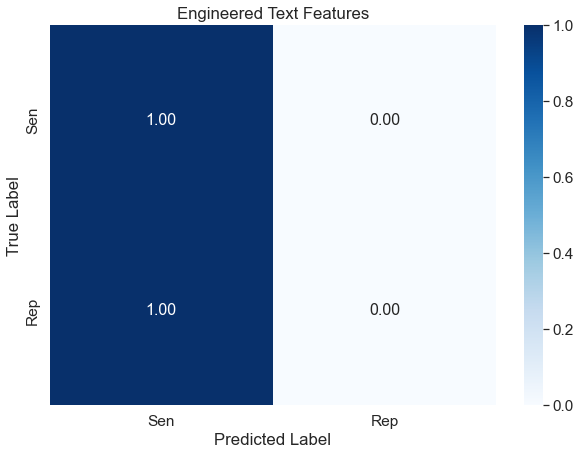

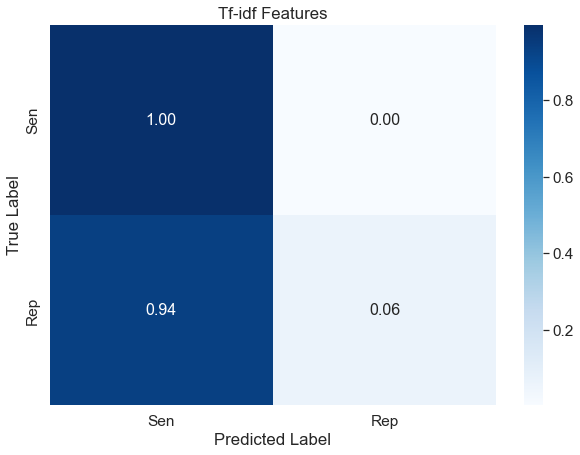

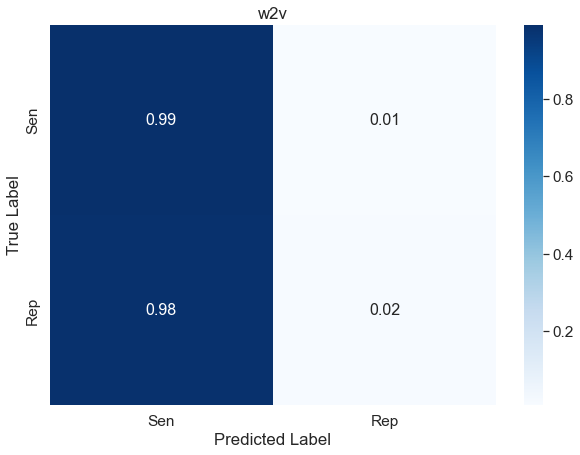

Featurization Technique: Engineered Text Features
Accuracy: 0.76
Recall: 0.00
Precision: 0.00
F1 Score: 0.00


Featurization Technique: Tf-idf Features
Accuracy: 0.77
Recall: 0.06
Precision: 0.87
F1 Score: 0.12


Featurization Technique: w2v
Accuracy: 0.76
Recall: 0.02
Precision: 0.35
F1 Score: 0.03




In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Initialize lists to store metrics
accuracies = []
recalls = []
precisions = []
f1_scores = []

# Loop over each dataframe, apply a logit classification model, and create a confusion matrix
for dataframe, featurization in zip(dataframes, featurization_technique):

    # Changing column names to strings because some are integers
    dataframe.columns = dataframe.columns.astype(str)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(dataframe, y, train_size=0.80, test_size=0.20, random_state=10)

    # Apply Logit model
    logit_reg = LogisticRegression(max_iter=500)
    logit_model = logit_reg.fit(X_train, y_train.ravel())
    y_pred = logit_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append metrics to lists
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

    # Create confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
    df_cm = pd.DataFrame(cf_matrix, index=["Sen", "Rep"], columns=["Sen", "Rep"])

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', cmap='Blues')
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Display evaluation metrics
for featurization, accuracy, recall, precision, f1 in zip(featurization_technique, accuracies, recalls, precisions, f1_scores):
    print(f"Featurization Technique: {featurization}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")


### Two Combined Models

#### Predicting on Party

In [44]:
non_text_plus_tfidf_p = non_text_plus_tfidf.drop(columns=['party', 'party_Democrat', 'party_Republican'])

In [45]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# preprocessing

# create a list of dataframes from the objects created above
dataframes = [non_text_plus_tfidf_p]


# create a list of labeles based on the objects created above
featurization_technique = ['Tf-idf Features + Non-text']

# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])

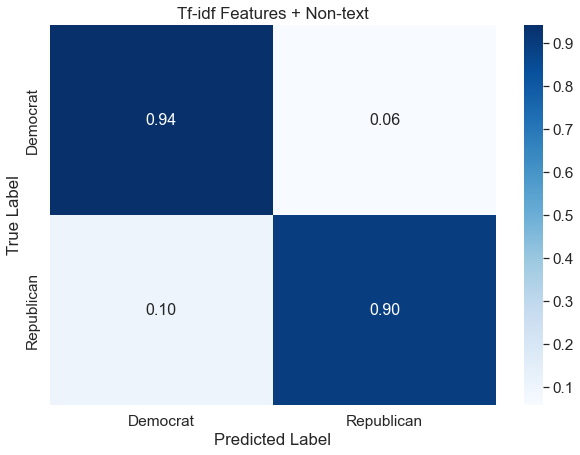

Featurization Technique: Tf-idf Features + Non-text
Accuracy: 0.93
Recall: 0.90
Precision: 0.89
F1 Score: 0.89




In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Initialize lists to store metrics
accuracies = []
recalls = []
precisions = []
f1_scores = []

# Loop over each dataframe, apply a logit classification model, and create a confusion matrix
for dataframe, featurization in zip(dataframes, featurization_technique):

    # Changing column names to strings because some are integers
    dataframe.columns = dataframe.columns.astype(str)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(dataframe, y, train_size=0.80, test_size=0.20, random_state=10)

    # Apply Logit model
    logit_reg = LogisticRegression(max_iter=500)
    logit_model = logit_reg.fit(X_train, y_train.ravel())
    y_pred = logit_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append metrics to lists
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

    # Create confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
    df_cm = pd.DataFrame(cf_matrix, index=["Democrat", "Republican"], columns=["Democrat", "Republican"])

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', cmap='Blues')
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Display evaluation metrics
for featurization, accuracy, recall, precision, f1 in zip(featurization_technique, accuracies, recalls, precisions, f1_scores):
    print(f"Featurization Technique: {featurization}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")


In [48]:
non_text_plus_tfidf_b = non_text_plus_tfidf.drop(columns=['position', 'position_Rep', 'position_Sen'])

In [49]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# preprocessing

# create a list of dataframes from the objects created above
dataframes = [non_text_plus_tfidf_b]


# create a list of labeles based on the objects created above
featurization_technique = ['Tf-idf Features + Non-text']

# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])
y

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

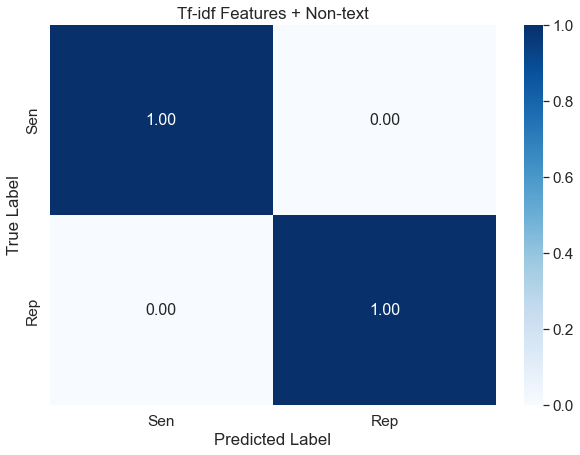

Featurization Technique: Tf-idf Features + Non-text
Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1 Score: 1.00




In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Initialize lists to store metrics
accuracies = []
recalls = []
precisions = []
f1_scores = []

# Loop over each dataframe, apply a logit classification model, and create a confusion matrix
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # Changing column names to strings because some are integers
    dataframe.columns = dataframe.columns.astype(str) 
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(dataframe, y, train_size=0.80, test_size=0.20, random_state=10)
    
    # Apply Logit model
    logit_reg = LogisticRegression(max_iter=500)
    logit_model = logit_reg.fit(X_train, y_train.ravel())
    y_pred = logit_model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Append metrics to lists
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

    # Create confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
    df_cm = pd.DataFrame(cf_matrix, index=["Sen", "Rep"], columns=["Sen", "Rep"])

    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', cmap='Blues')
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Display evaluation metrics
for featurization, accuracy, recall, precision, f1 in zip(featurization_technique, accuracies, recalls, precisions, f1_scores):
    print(f"Featurization Technique: {featurization}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")


## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Standard preprocessing techniques need to be further customized to a particular corpus because each corpus may have unique language quirks. Some corpora, like ones composed of tweets, contain very domain-specific terminology, such as words like 'rt' or specific emojis that may or may not need to be filtered out in preprocessing. However, these domain-specific words may carry extra significance in corpora where documents are constrained by word or character count. 

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

In [ ]:
# Group by 'party' and calculate mean and standard deviation of polarity
stats_by_party = congress_tweets.groupby('party')['polarity'].agg(['mean', 'std'])

# Group by 'position' and calculate mean and standard deviation of polarity
stats_by_position = congress_tweets.groupby('position')['polarity'].agg(['mean', 'std'])

print("Mean and Standard Deviation of Sentiment by Party:")
print(stats_by_party)

print("\nMean and Standard Deviation of Sentiment by Position:")
print(stats_by_position)


My results suggest that both Democrats and Republicans and Senators and Representatives tweet with similar sentiment. I was pretty surprised by this result and was expecting Republicans, in particular, to tweet using more negative sentiment. I suspect that the similarity might be a function of the COVID pandemic (which wasn't as politicized during this period) and the fact that a Republican was in the presidential office during this time. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Validating exploratory and unsupervised learning approaches with a supervised learning algorithm is useful for several reasons. Perhaps most importantly, supervised learning algorithms can be used to evaluate the performance of unsupervised algorithms using accuracy, precision, recall, and F1-score metrics. Additionally, supervised machine learning algorithms can be used for feature engineering and tuning the hyperparamters of unsupervised models, though we did not do use this application during this project.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The combination of text and non-text features performed the best--specifically the term frequency-inverse document frequency and non-text feature combination. I was initially surprised that tf-idf outperformed the word embeddings model (as an aside, I could not get the doc2vec model to run), though this might be due to the fact that the words used in tweets vary by party affiliation and position or that the model provides a sparse representation of the text, which is well suited for short-texts.

Moving on, the intuition behind combining text and non-text features in a supervised learning algorithm is that we can leverage multiple source of information to improve our algorithm's predictive power. Text and non-text features offer distinct insights into the data. Non-textual metadata in this project helped us factor in political party, position, tenure, and key election results into our models, which added more context to the tweets. By merging these diverse sources, we achieve a more comprehensive understanding of the underlying data patterns.